In [1]:
import tensorflow as tf
from tensorflow import keras

import math
import os

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
    'font.size': 16
})

SAVE_FIG = True

def save_fig(name, tight_layout = True):
    if SAVE_FIG:
        if not os.path.isdir("plots"):
            os.mkdir("plots")
        print(f"Saving figure {name} ...")
        if tight_layout:
            plt.tight_layout(pad=0.4)
        plt.savefig(f"plots/{name}.pdf", backend="pgf")

In [2]:
print(tf.__version__)

2.5.0


In [3]:
xs = tf.linspace(0, 14, 4000)
ys = tf.math.sin(xs)

Saving figure sine-curve ...


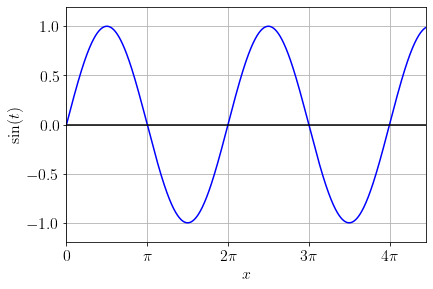

In [4]:
plt.plot(xs, ys, "b-")
plt.plot()
plt.grid()
plt.plot([-10, 20], [0, 0], "k-")
plt.axis([0, 14, -1.2, 1.2])
plt.xlabel("$x$")
plt.ylabel("$\sin(t)$")
plt.xticks(tf.range(0, 5 * math.pi, math.pi), ["0", "$\pi$", "$2\pi$", "$3\pi$", "$4\pi$"])
save_fig("sine-curve")
plt.show()

Saving figure sine-data ...


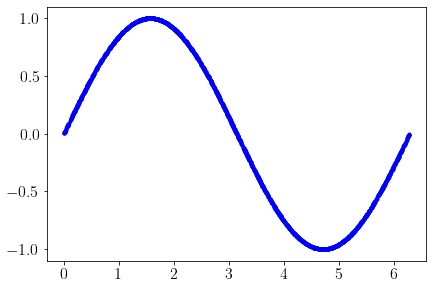

In [5]:
SAMPLES = 2000

tf.random.set_seed(42)

x = tf.random.uniform((SAMPLES, 1), minval=0, maxval=2*math.pi)

tf.random.shuffle(x)

y = tf.math.sin(x)

plt.plot(x, y, "b.")
save_fig("sine-data")
plt.show()

Saving figure sine-data-noise ...


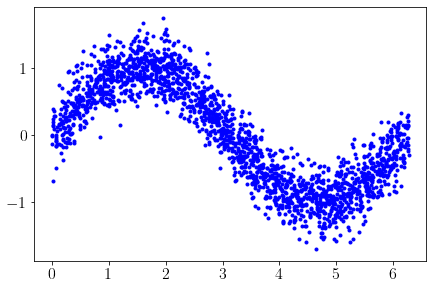

In [6]:
y += 0.25 * tf.random.normal(y.shape)
plt.plot(x, y, "b.")
save_fig("sine-data-noise")
plt.show()

In [7]:
TRAIN_SPLIT = int(0.5 * SAMPLES)
TEST_SPLIT = int(0.2 * SAMPLES)
VAL_SPLIT = SAMPLES - TRAIN_SPLIT - TEST_SPLIT

x_train, x_test, x_val = tf.split(x, [TRAIN_SPLIT, TEST_SPLIT, VAL_SPLIT])
y_train, y_test, y_val = tf.split(y, [TRAIN_SPLIT, TEST_SPLIT, VAL_SPLIT])

assert tf.size(x_train) + tf.size(x_test) + tf.size(x_val) == SAMPLES

Saving figure sine-data-noise-legend ...


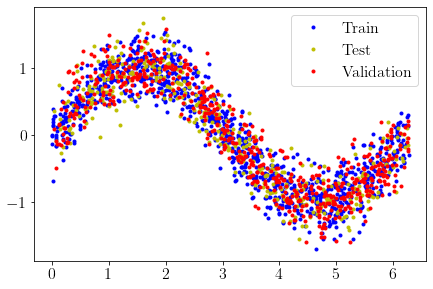

In [8]:
plt.plot(x_train, y_train, "b.", label="Train")
plt.plot(x_test, y_test, "y.", label="Test")
plt.plot(x_val, y_val, "r.", label="Validation")
plt.legend()
save_fig("sine-data-noise-legend")
plt.show()

In [9]:
input_layer = keras.layers.Input(shape=[1])
hidden1 = keras.layers.Dense(16, activation="relu", name="hidden1")(input_layer)
output = keras.layers.Dense(1, name="output")(hidden1)
model_1 = keras.Model(inputs=input_layer, outputs=output)

In [10]:
model_1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
hidden1 (Dense)              (None, 16)                32        
_________________________________________________________________
output (Dense)               (None, 1)                 17        
Total params: 49
Trainable params: 49
Non-trainable params: 0
_________________________________________________________________


In [11]:
sgd = tf.keras.optimizers.SGD()
model_1.compile(optimizer=sgd, loss="mse", metrics=["mae"])

In [12]:
EPOCHS = 200
BATCH_SIZE = 16
history_1 = model_1.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(x_val, y_val))

Epoch 1/200
63/63 [==============================] - 1s 4ms/step - loss: 0.6604 - mae: 0.6518 - val_loss: 0.3933 - val_mae: 0.5314
Epoch 2/200
63/63 [==============================] - 0s 3ms/step - loss: 0.3702 - mae: 0.5132 - val_loss: 0.3066 - val_mae: 0.4688
Epoch 3/200
63/63 [==============================] - 0s 3ms/step - loss: 0.3042 - mae: 0.4662 - val_loss: 0.2644 - val_mae: 0.4351
Epoch 4/200
63/63 [==============================] - 0s 3ms/step - loss: 0.2747 - mae: 0.4418 - val_loss: 0.2420 - val_mae: 0.4140
Epoch 5/200
63/63 [==============================] - 0s 3ms/step - loss: 0.2567 - mae: 0.4244 - val_loss: 0.2458 - val_mae: 0.4154
Epoch 6/200
63/63 [==============================] - 0s 3ms/step - loss: 0.2470 - mae: 0.4141 - val_loss: 0.2372 - val_mae: 0.4056
Epoch 7/200
63/63 [==============================] - 0s 3ms/step - loss: 0.2421 - mae: 0.4092 - val_loss: 0.2523 - val_mae: 0.4082
Epoch 8/200
63/63 [==============================] - 0s 3ms/step - loss: 0.2392 - m

In [13]:
history_1.history.keys()

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])

In [14]:
loss_1 = history_1.history["loss"]
val_loss_1 = history_1.history["val_loss"]
assert len(loss_1) == len(val_loss_1) == EPOCHS

Saving figure 1-kosten ...


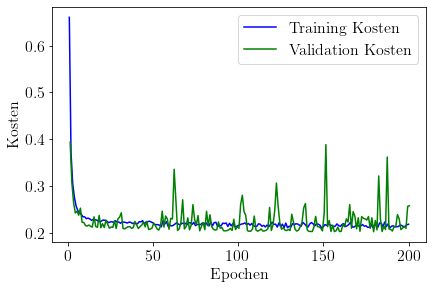

In [15]:
train_epochs = tf.range(1.0, EPOCHS + 1)
val_epochs = train_epochs + 0.5

plt.plot(train_epochs, loss_1, "b-", label="Training Kosten")
plt.plot(val_epochs, val_loss_1, "g-", label="Validation Kosten")
plt.xlabel("Epochen")
plt.ylabel("Kosten")
plt.legend()
save_fig(f"1-kosten")
plt.show()

Saving figure 1-mae ...


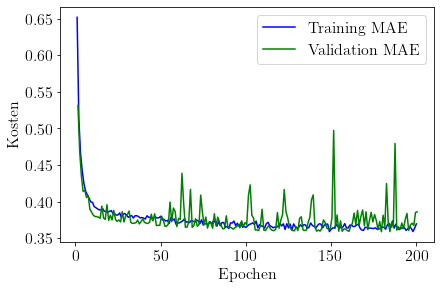

In [16]:
mae_1 = history_1.history["mae"]
val_mae_1 = history_1.history["val_mae"]

plt.plot(train_epochs, mae_1, "b-", label="Training MAE")
plt.plot(val_epochs, val_mae_1, "g-", label="Validation MAE")
plt.xlabel("Epochen")
plt.ylabel("Kosten")
plt.legend()
save_fig(f"1-mae")
plt.show()

Saving figure 1-prognosen ...


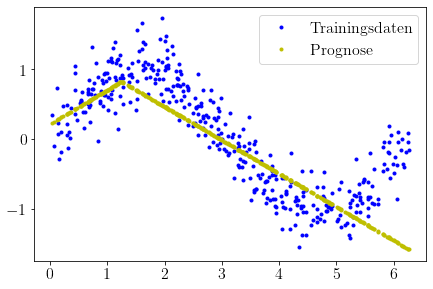

In [17]:
predictions_1 = model_1.predict(x_test)

plt.plot(x_test, y_test, "b.", label="Trainingsdaten")
plt.plot(x_test, predictions_1, "y.", label="Prognose")
plt.legend()
save_fig(f"1-prognosen")
plt.show()

In [18]:
input_layer = keras.layers.Input(shape=[1])
hidden1 = keras.layers.Dense(16, activation="relu", name="hidden1")(input_layer)
hidden2 = keras.layers.Dense(64, activation="relu", name="hidden2")(hidden1)
output = keras.layers.Dense(1, name="output")(hidden2)
model_2 = keras.Model(inputs=input_layer, outputs=output)

In [19]:
model_2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
hidden1 (Dense)              (None, 16)                32        
_________________________________________________________________
hidden2 (Dense)              (None, 64)                1088      
_________________________________________________________________
output (Dense)               (None, 1)                 65        
Total params: 1,185
Trainable params: 1,185
Non-trainable params: 0
_________________________________________________________________


In [20]:
sgd = tf.keras.optimizers.SGD()
model_2.compile(optimizer=sgd, loss="mse", metrics=["mae"])

In [21]:
EPOCHS = 200

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=EPOCHS,
    monitor="loss",
    verbose=1,
    restore_best_weights=True)

history_2 = model_2.fit(
    x_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping_cb])

Epoch 1/200
63/63 [==============================] - 0s 4ms/step - loss: 0.5282 - mae: 0.6035 - val_loss: 0.3558 - val_mae: 0.5051
Epoch 2/200
63/63 [==============================] - 0s 3ms/step - loss: 0.3355 - mae: 0.4885 - val_loss: 0.2750 - val_mae: 0.4420
Epoch 3/200
63/63 [==============================] - 0s 3ms/step - loss: 0.2758 - mae: 0.4427 - val_loss: 0.2415 - val_mae: 0.4140
Epoch 4/200
63/63 [==============================] - 0s 3ms/step - loss: 0.2531 - mae: 0.4199 - val_loss: 0.2239 - val_mae: 0.3954
Epoch 5/200
63/63 [==============================] - 0s 3ms/step - loss: 0.2375 - mae: 0.4030 - val_loss: 0.2386 - val_mae: 0.4042
Epoch 6/200
63/63 [==============================] - 0s 3ms/step - loss: 0.2280 - mae: 0.3922 - val_loss: 0.2273 - val_mae: 0.3923
Epoch 7/200
63/63 [==============================] - 0s 3ms/step - loss: 0.2250 - mae: 0.3894 - val_loss: 0.2559 - val_mae: 0.4010
Epoch 8/200
63/63 [==============================] - 0s 3ms/step - loss: 0.2224 - m

Saving figure 2-kosten ...


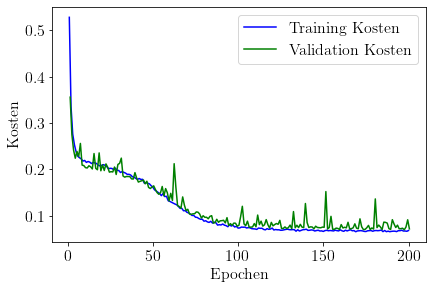

Saving figure 2-kosten-limit ...


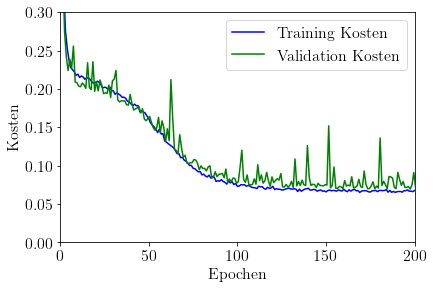

In [22]:
loss_2 = history_2.history["loss"]
val_loss_2 = history_2.history["val_loss"]

train_epochs = tf.range(1.0, EPOCHS + 1)
val_epochs = train_epochs + 0.5

plt.plot(train_epochs, loss_2, "b-", label="Training Kosten")
plt.plot(val_epochs, val_loss_2, "g-", label="Validation Kosten")
plt.xlabel("Epochen")
plt.ylabel("Kosten")
plt.legend()
save_fig("2-kosten")
plt.show()

plt.plot(train_epochs, loss_2, "b-", label="Training Kosten")
plt.plot(val_epochs, val_loss_2, "g-", label="Validation Kosten")
plt.xlabel("Epochen")
plt.ylabel("Kosten")
plt.legend()
plt.axis([0, EPOCHS, 0, 0.3])
save_fig("2-kosten-limit")
plt.show()

Saving figure 2-mae ...


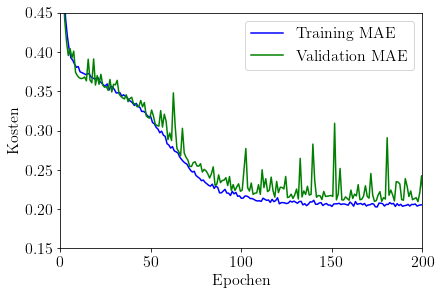

In [23]:
mae_2 = history_2.history["mae"]
val_mae_2 = history_2.history["val_mae"]
plt.plot(train_epochs, mae_2, "b-", label="Training MAE")
plt.plot(val_epochs, val_mae_2, "g-", label="Validation MAE")
plt.xlabel("Epochen")
plt.ylabel("Kosten")
plt.legend()
plt.axis([0, EPOCHS, 0.15, 0.45])
save_fig("2-mae")
plt.show()

Saving figure 2-prognosen ...


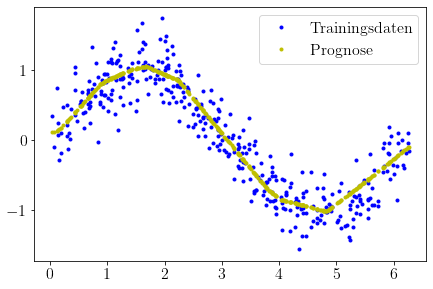

In [24]:
predictions_2 = model_2.predict(x_test)
plt.plot(x_test, y_test, "b.", label="Trainingsdaten")
plt.plot(x_test, predictions_2, "y.", label="Prognose")
plt.legend()
save_fig("2-prognosen")
plt.show()

In [25]:
def save_model(model, model_name: str):
    with open(model_name, "wb") as f:
        f.write(model)

In [26]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_2)
tflite_model = converter.convert()

save_model(tflite_model, "sine_model.tflite")

INFO:tensorflow:Assets written to: C:\Users\jens\AppData\Local\Temp\tmph_uw1slt\assets


In [27]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_2)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

def representative_dataset():
    for value in x_test:
        yield [value]

converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
tflite_model = converter.convert()

save_model(tflite_model, "sine_model_quant.tflite")

INFO:tensorflow:Assets written to: C:\Users\jens\AppData\Local\Temp\tmp6d621qyq\assets


INFO:tensorflow:Assets written to: C:\Users\jens\AppData\Local\Temp\tmp6d621qyq\assets


In [28]:
sine_model = tf.lite.Interpreter("sine_model.tflite")
sine_model_quant = tf.lite.Interpreter("sine_model_quant.tflite")

sine_model.allocate_tensors()
sine_model_quant.allocate_tensors()

input_details = sine_model.get_input_details()[0]
output_details = sine_model.get_output_details()[0]

input_details_quant = sine_model_quant.get_input_details()[0]
output_details_quant = sine_model_quant.get_output_details()[0]

input_scale, input_zero_point = input_details_quant["quantization"]

input_index = input_details["index"]
output_index = output_details["index"]

input_index_quant = input_details_quant["index"]
output_index_quant = output_details_quant["index"]

sine_model_predictions = []
sine_model_quant_predictions = []

for value in x_test:
    tensor_float32 = tf.convert_to_tensor([value], dtype=tf.float32)
    tensor_int8 = tf.convert_to_tensor([value / input_scale + input_zero_point], dtype=tf.int8)

    sine_model.set_tensor(input_index, tensor_float32)
    sine_model_quant.set_tensor(input_index_quant, tensor_int8)

    sine_model.invoke()
    sine_model_quant.invoke()

    sine_model_predictions.append(
        sine_model.get_tensor(output_index)[0,0]
    )
    sine_model_quant_predictions.append(
        sine_model_quant.get_tensor(output_index_quant)[0,0] / 128
    )

Saving figure model-comparison ...


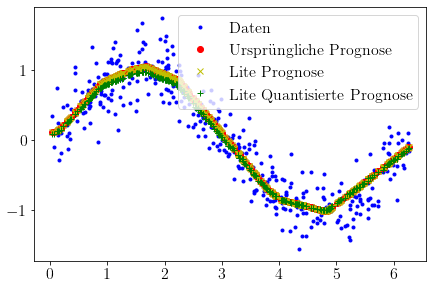

In [29]:
plt.plot(x_test, y_test, "b.", label="Daten")
plt.plot(x_test, predictions_2, "ro", label="Ursprüngliche Prognose")
plt.plot(x_test, sine_model_predictions, "yx", label="Lite Prognose")
plt.plot(x_test, sine_model_quant_predictions, "g+", label="Lite Quantisierte Prognose")
plt.legend()
save_fig("model-comparison")
plt.show()

In [30]:
import os
sine_size = os.path.getsize("sine_model.tflite")
print(f"Sine model size: {sine_size}")
sine_quant_size = os.path.getsize("sine_model_quant.tflite")
print(f"Sine quant model size: {sine_quant_size}")

Sine model size: 6272
Sine quant model size: 3320


In [31]:
import platform

EDGETUP_LIB = {
    "Linux": "libedgetpu.so.1",
    "Darwin": "libedgetpu.1.dylib",
    "Windows": "edgetpu.dll",
}[platform.system()]

delegates = [tf.lite.experimental.load_delegate(EDGETUP_LIB)]
sine_model_tpu = tf.lite.Interpreter(
    "sine_model_quant_edgetpu.tflite",
    experimental_delegates=delegates
)

sine_model_tpu.allocate_tensors()

input_details_tpu = sine_model_tpu.get_input_details()[0]
output_details_tpu = sine_model_tpu.get_output_details()[0]

input_index_tpu = input_details_tpu["index"]
output_index_tpu = output_details_tpu["index"]

In [32]:
import time

values = tf.random.uniform((2000, 1, 1), minval=1, maxval=5)
values = values / input_scale + input_zero_point
values = tf.cast(values, dtype=tf.int8)

start = time.perf_counter()
for value in values:
    sine_model_tpu.set_tensor(input_index_tpu, value)
    sine_model_tpu.invoke()
inference_time = (time.perf_counter() - start) * 1000

print(inference_time)

1045.2961000000016


In [33]:
values = tf.random.uniform((2000, 1, 1), minval=1, maxval=5)
values = values / input_scale + input_zero_point
values = tf.cast(values, dtype=tf.int8)

start = time.perf_counter()
for value in values:
    sine_model_quant.set_tensor(input_index_tpu, value)
    sine_model_quant.invoke()
inference_time = (time.perf_counter() - start) * 1000

print(inference_time)

452.3481000000089
